# Multi-Scenario MORDM

Multi-scenario MORMD is an extension of normal MORDM to better include robustness considerations within the search phase. It starts from the scenario discovery results resulting from MORDM. Next, from the experiments within this box, a set of scenarios is selected. 


In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter,
                           MultiprocessingEvaluator, Policy, Scenario)

from dike_model_function import DikeNetwork  # @UnresolvedImport


def sum_over(*args):
    return sum(args)

from ema_workbench import (Model, )

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time

from problem_formulation import get_model_for_problem_formulation


ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-5
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [3]:
uncertainties = dike_model.uncertainties
levers = dike_model.levers 

import copy
uncertainties = copy.deepcopy(dike_model.uncertainties)
levers = copy.deepcopy(dike_model.levers)

## Finding scenarios
#running the model through EMA workbench
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments, SequentialEvaluator)
ema_logging.log_to_stderr(ema_logging.INFO)
 
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=10, policies = 3)

or import already available experiments

In [4]:
import pandas as pd
#from ema_workbench import load_results

#experiments, outcomes = load_results('mordm_42.tar.gz')
#y = outcomes['utility'] < 0.35
experiments = pd.read_csv('outcomes/Experiments_from_Exploration_1000scenarios_100Policies_pf5.csv')
outcomes_100000 = pd.read_csv('outcomes/Outcomes_totals_from_Exploration_1000scenarios_100Policies_pf5.csv')
outcomes_100000.head()

,Unnamed: 0,A.1_Expected Total Damage,A.1_Total Dike Investment Costs,A.1_Total Expected Number of Deaths,A.2_Expected Total Damage,A.2_Total Dike Investment Costs,A.2_Total Expected Number of Deaths,A.3_Expected Total Damage,A.3_Total Dike Investment Costs,A.3_Total Expected Number of Deaths,...,A.4_Total Dike Investment Costs,A.4_Total Expected Number of Deaths,A.5_Expected Total Damage,A.5_Total Dike Investment Costs,A.5_Total Expected Number of Deaths,RfR Total Costs,Total Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Dike Investment Costs,Other Areas Total Damage
0,0,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,0.000000e+00,1.242050e+08,0.000000,...,2.416243e+07,0.0,1.018132e+06,1.342366e+08,0.000253,1.397700e+09,23.209601,0.000000,5.595331e+08,0.000000e+00
1,1,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,3.036115e+06,1.242050e+08,0.001489,...,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,48.414519,0.001489,5.595331e+08,3.036115e+06
2,2,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,1.740958e+08,1.242050e+08,0.128044,...,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,5057.037941,0.128044,5.595331e+08,1.740958e+08
3,3,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,2.703954e+07,1.242050e+08,0.013140,...,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,435.421645,0.013140,5.595331e+08,2.703954e+07
4,4,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,0.000000e+00,1.242050e+08,0.000000,...,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,0.000000,0.000000,5.595331e+08,0.000000e+00


import numpy
sum(outcomes_100000['A.5_Dike Investment Costs 2']==numpy.nan)

In [5]:
experiments_DF = pd.DataFrame(experiments)
experiments_DF = experiments_DF.iloc[:, 1:]
experiments_DF.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,EWS_DaysToThreat,scenario,policy,model
0,126.0,223.622426,1.0,0.871722,218.831042,1.0,0.705490,237.027027,10.0,0.852197,...,5.0,0.0,5.0,4.0,8.0,3.0,1.0,0,0,dikesnet
1,79.0,298.108524,1.0,0.100861,232.253542,1.0,0.104278,33.997448,1.5,0.316080,...,5.0,0.0,5.0,4.0,8.0,3.0,1.0,1,0,dikesnet
2,80.0,275.541284,10.0,0.200497,229.990714,1.5,0.055838,114.045936,1.5,0.031793,...,5.0,0.0,5.0,4.0,8.0,3.0,1.0,2,0,dikesnet
3,15.0,200.546816,1.0,0.000321,281.785818,1.0,0.018157,162.548088,1.0,0.153352,...,5.0,0.0,5.0,4.0,8.0,3.0,1.0,3,0,dikesnet
4,120.0,312.688358,1.5,0.202780,334.804942,1.5,0.047327,178.394116,1.5,0.513973,...,5.0,0.0,5.0,4.0,8.0,3.0,1.0,4,0,dikesnet


there are many ways in which you can make an informed selection. Examples include
* --> pick best and worst for each outcome of interest
* maximize diversity following Eker & Kwakkel
* visually selected them

## best case, worst case

In [6]:
outcomes_DF = pd.DataFrame(outcomes_100000)
outcomes_DF = outcomes_DF.iloc[:, 1:]
outcomes_DF.head()

,A.1_Expected Total Damage,A.1_Total Dike Investment Costs,A.1_Total Expected Number of Deaths,A.2_Expected Total Damage,A.2_Total Dike Investment Costs,A.2_Total Expected Number of Deaths,A.3_Expected Total Damage,A.3_Total Dike Investment Costs,A.3_Total Expected Number of Deaths,A.4_Expected Total Damage,A.4_Total Dike Investment Costs,A.4_Total Expected Number of Deaths,A.5_Expected Total Damage,A.5_Total Dike Investment Costs,A.5_Total Expected Number of Deaths,RfR Total Costs,Total Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Dike Investment Costs,Other Areas Total Damage
0,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,0.000000e+00,1.242050e+08,0.000000,0.0,2.416243e+07,0.0,1.018132e+06,1.342366e+08,0.000253,1.397700e+09,23.209601,0.000000,5.595331e+08,0.000000e+00
1,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,3.036115e+06,1.242050e+08,0.001489,0.0,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,48.414519,0.001489,5.595331e+08,3.036115e+06
2,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,1.740958e+08,1.242050e+08,0.128044,0.0,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,5057.037941,0.128044,5.595331e+08,1.740958e+08
3,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,2.703954e+07,1.242050e+08,0.013140,0.0,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,435.421645,0.013140,5.595331e+08,2.703954e+07
4,0.0,2.369736e+08,0.0,0.0,1.741921e+08,0.0,0.000000e+00,1.242050e+08,0.000000,0.0,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09,0.000000,0.000000,5.595331e+08,0.000000e+00


outcomes_DF['A.5_Total Expected Number of Deaths'] = outcomes_DF['A.5_Expected Number of Deaths 0'] + outcomes_DF['A.5_Expected Number of Deaths 1'] + outcomes_DF['A.5_Expected Number of Deaths 2']
outcomes_DF.head()

In [7]:
outcomes_DF.columns

Index(['A.1_Expected Total Damage', 'A.1_Total Dike Investment Costs',
       'A.1_Total Expected Number of Deaths', 'A.2_Expected Total Damage',
       'A.2_Total Dike Investment Costs',
       'A.2_Total Expected Number of Deaths', 'A.3_Expected Total Damage',
       'A.3_Total Dike Investment Costs',
       'A.3_Total Expected Number of Deaths', 'A.4_Expected Total Damage',
       'A.4_Total Dike Investment Costs',
       'A.4_Total Expected Number of Deaths', 'A.5_Expected Total Damage',
       'A.5_Total Dike Investment Costs',
       'A.5_Total Expected Number of Deaths', 'RfR Total Costs',
       'Total Expected Evacuation Costs', 'Other Areas Total Number of Deaths',
       'Other Areas Total Dike Investment Costs', 'Other Areas Total Damage'],
      dtype='object')

In [8]:
outcomes_DF.describe()

,A.1_Expected Total Damage,A.1_Total Dike Investment Costs,A.1_Total Expected Number of Deaths,A.2_Expected Total Damage,A.2_Total Dike Investment Costs,A.2_Total Expected Number of Deaths,A.3_Expected Total Damage,A.3_Total Dike Investment Costs,A.3_Total Expected Number of Deaths,A.4_Expected Total Damage,A.4_Total Dike Investment Costs,A.4_Total Expected Number of Deaths,A.5_Expected Total Damage,A.5_Total Dike Investment Costs,A.5_Total Expected Number of Deaths,RfR Total Costs,Total Expected Evacuation Costs,Other Areas Total Number of Deaths,Other Areas Total Dike Investment Costs,Other Areas Total Damage
count,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,1.000000e+05,100000.000000,1.000000e+05,100000.000000,100000.000000,1.000000e+05,1.000000e+05
mean,1.276797e+07,1.959147e+08,0.002697,1.137124e+07,2.128904e+08,0.003479,1.732500e+07,1.023240e+08,0.010536,1.343025e+06,4.060948e+07,0.000270,1.085142e+07,1.312995e+08,0.003768,1.065600e+09,1675.352973,0.016982,5.517386e+08,4.280724e+07
std,1.244361e+08,6.320409e+07,0.029632,4.972022e+07,6.690569e+07,0.018288,1.019537e+08,3.432606e+07,0.075005,5.764542e+06,1.384013e+07,0.001472,4.523676e+07,4.578073e+07,0.020274,3.022188e+08,5174.331111,0.082894,9.861232e+07,1.698104e+08
min,0.000000e+00,3.725520e+07,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,2.029929e+07,0.000000,0.000000e+00,6.320800e+06,0.000000,0.000000e+00,2.757823e+07,0.000000,3.175000e+08,0.000000,0.000000,2.965656e+08,0.000000e+00
25%,0.000000e+00,1.495644e+08,0.000000,0.000000e+00,1.666741e+08,0.000000,0.000000e+00,7.843142e+07,0.000000,0.000000e+00,3.053799e+07,0.000000,0.000000e+00,1.021137e+08,0.000000,8.737250e+08,0.000000,0.000000,4.904318e+08,0.000000e+00
50%,0.000000e+00,1.919602e+08,0.000000,0.000000e+00,2.034182e+08,0.000000,0.000000e+00,1.020692e+08,0.000000,0.000000e+00,4.017411e+07,0.000000,0.000000e+00,1.301568e+08,0.000000,1.038650e+09,60.999470,0.000178,5.558432e+08,1.100395e+06
75%,0.000000e+00,2.404412e+08,0.000000,1.940094e+06,2.589319e+08,0.000344,0.000000e+00,1.260934e+08,0.000000,0.000000e+00,4.967220e+07,0.000000,0.000000e+00,1.651665e+08,0.000000,1.266300e+09,978.612833,0.004289,6.174991e+08,1.511583e+07
max,3.100173e+09,3.616211e+08,1.077283,9.881824e+08,4.150130e+08,0.506282,2.106271e+09,1.790965e+08,2.892501,1.098192e+08,8.437076e+07,0.038685,9.805268e+08,2.426556e+08,0.645636,1.894700e+09,88594.268297,2.892501,8.522368e+08,3.102450e+09


In [9]:
outcomes_A45 = outcomes_DF.loc[:,['A.4_Total Dike Investment Costs','A.4_Total Expected Number of Deaths', 
                           'A.5_Expected Total Damage', 'A.5_Total Dike Investment Costs','A.5_Total Expected Number of Deaths', 'RfR Total Costs']]
outcomes_A45

,A.4_Total Dike Investment Costs,A.4_Total Expected Number of Deaths,A.5_Expected Total Damage,A.5_Total Dike Investment Costs,A.5_Total Expected Number of Deaths,RfR Total Costs
0,2.416243e+07,0.0,1.018132e+06,1.342366e+08,0.000253,1.397700e+09
1,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09
2,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09
3,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09
4,2.416243e+07,0.0,0.000000e+00,1.342366e+08,0.000000,1.397700e+09
...,...,...,...,...,...,...
99995,3.837646e+07,0.0,0.000000e+00,1.476252e+08,0.000000,1.203000e+09
99996,3.837646e+07,0.0,0.000000e+00,1.476252e+08,0.000000,1.203000e+09
99997,3.837646e+07,0.0,0.000000e+00,1.476252e+08,0.000000,1.203000e+09
99998,3.837646e+07,0.0,0.000000e+00,1.476252e+08,0.000000,1.203000e+09


In [10]:
y = outcomes_A45['A.5_Total Expected Number of Deaths'] > 1/10 # too many, just for the sake of demonstration

data = pd.DataFrame({k:v[y] for k,v in outcomes_A45.items()})
all_data = pd.DataFrame({k:v for k,v in outcomes_A45.items()})

In [11]:
ylist = y.tolist()

# check how many truw in list
def count(lst): 
    return sum(bool(x) for x in lst)      
print(count(ylist))

813


C:\Users\thori\Anaconda3\envs\mbdm1\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive "


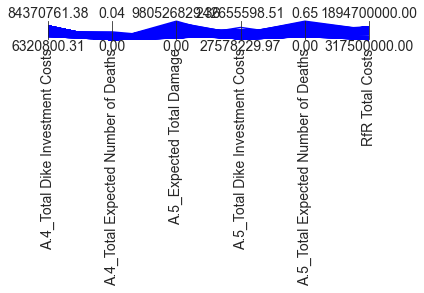

<Figure size 14400x14400 with 0 Axes>

In [12]:
#way too much data --> focus on some 
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

limits = parcoords.get_limits(all_data)

axes = parcoords.ParallelAxes(limits)

#fig, ax = plt.figure()
figure(figsize=(200, 200))
#axes.plot(all_data, color='lightgrey')
axes.plot(data, color='blue')

plt.show()

data.head()

data.describe()

in the next step, we select worst case scenarios

In [ ]:
#take worst value in each column
maxrow = data.idxmax()
maxrow = maxrow.tolist()
#take best value in each column
minrow = data.idxmin()
minrow = minrow.tolist()

In [13]:
# take worst values for total deaths
row_high_death = data.loc[data['A.5_Total Expected Number of Deaths'] > 0.5]
row_high_death = row_high_death.index
row_high_death = row_high_death.tolist()
row_high_death

[21462,
 21587,
 21682,
 21731,
 21780,
 21819,
 64266,
 64323,
 64462,
 64521,
 64540,
 64587,
 64682,
 64780,
 64819,
 64882]

In [14]:
experiments_DF.columns

Index(['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail', 'discount rate 0', 'discount rate 1',
       'discount rate 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2',
       'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2',
       'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2',
       'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2',
       'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2',
       'EWS_DaysToThreat', 'scenario', 'policy', 'model'],
      dtype='object')

In [15]:
# also all we need are the uncertainty columns --> for maxrows
experiments_uncert = experiments_DF.loc[:, ['A.0_ID flood wave shape', 'A.1_Bmax', 'A.1_Brate', 'A.1_pfail',
       'A.2_Bmax', 'A.2_Brate', 'A.2_pfail', 'A.3_Bmax', 'A.3_Brate',
       'A.3_pfail', 'A.4_Bmax', 'A.4_Brate', 'A.4_pfail', 'A.5_Bmax',
       'A.5_Brate', 'A.5_pfail']]
experiments_uncert

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail
0,126.0,223.622426,1.0,0.871722,218.831042,1.0,0.705490,237.027027,10.0,0.852197,122.745031,10.0,0.276320,133.842486,1.0,0.177182
1,79.0,298.108524,1.0,0.100861,232.253542,1.0,0.104278,33.997448,1.5,0.316080,134.287863,1.0,0.254493,206.265410,1.5,0.926149
2,80.0,275.541284,10.0,0.200497,229.990714,1.5,0.055838,114.045936,1.5,0.031793,305.444359,1.5,0.620158,222.904181,1.5,0.273655
3,15.0,200.546816,1.0,0.000321,281.785818,1.0,0.018157,162.548088,1.0,0.153352,262.402559,10.0,0.977910,226.391822,1.0,0.277829
4,120.0,312.688358,1.5,0.202780,334.804942,1.5,0.047327,178.394116,1.5,0.513973,74.210712,1.5,0.565032,199.306059,1.5,0.960193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,47.0,265.255792,1.5,0.909054,316.145453,10.0,0.658270,124.898641,1.5,0.116861,79.788579,1.5,0.133068,157.102355,10.0,0.204232
99996,7.0,229.679234,1.5,0.682534,195.987328,10.0,0.372328,125.288218,1.0,0.503063,59.522079,10.0,0.206807,333.388226,1.0,0.050302
99997,87.0,270.489824,1.5,0.289764,308.633490,1.0,0.017149,119.919107,1.5,0.212751,281.082866,10.0,0.760607,69.467154,1.5,0.380181
99998,110.0,69.668058,10.0,0.419785,30.676658,1.5,0.934342,288.362075,1.0,0.493618,322.113563,10.0,0.221228,93.493028,10.0,0.862462


In [16]:
selected = experiments_uncert.loc[row_high_death, experiments_uncert.columns[:]]
selected

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail
21462,75.0,110.135623,1.0,0.509537,226.629336,10.0,0.367084,85.981938,1.5,0.816194,190.377393,1.0,0.637163,341.860573,1.0,0.002454
21587,104.0,96.562103,1.0,0.765842,198.747874,1.0,0.940758,115.717538,1.5,0.743451,108.738128,1.0,0.169897,219.685604,10.0,0.004859
21682,22.0,247.631754,1.0,0.814604,108.813284,1.0,0.513680,245.721256,10.0,0.450826,132.200002,1.5,0.877026,313.925759,1.5,0.003700
21731,41.0,91.096511,10.0,0.001297,300.011472,1.0,0.096849,331.126590,1.5,0.701429,58.378830,1.5,0.646989,86.634386,1.5,0.000993
21780,20.0,133.292348,10.0,0.635681,282.862724,10.0,0.242201,123.826512,1.0,0.413829,71.915964,10.0,0.634631,170.584954,1.0,0.005087
21819,5.0,259.418962,10.0,0.783973,50.301659,1.0,0.518480,178.574143,10.0,0.520274,151.729270,1.5,0.150480,56.440588,1.0,0.001497
64266,112.0,193.150509,10.0,0.990240,80.042670,10.0,0.317445,53.670594,1.0,0.873124,308.121609,10.0,0.140226,101.873324,1.5,0.012940
64323,126.0,269.639014,1.0,0.351077,322.179020,10.0,0.771631,341.247871,10.0,0.299240,114.036297,1.0,0.470457,106.127122,10.0,0.009391
64462,75.0,110.135623,1.0,0.509537,226.629336,10.0,0.367084,85.981938,1.5,0.816194,190.377393,1.0,0.637163,341.860573,1.0,0.002454
64521,67.0,235.418596,1.5,0.830730,37.343842,10.0,0.923498,319.598667,10.0,0.978417,44.394150,1.5,0.136763,89.357567,1.0,0.007456


## Search for each scenario

For each of the four selected scenarios, use many-objective optimization to find a pareto approximate set using the same approach as for assignment 8. Remember to check for convergence (and time permitting, seed analysis), and be careful in what epsilon values to use (not to coarse, not too small). 

Store the resulting set of pareto solutions in a smart way for subsequent analysis.


Since we have to do the same thing for each scenario, it is convenient to wrap this in a function we can call with the scenario under which we want to optimize. 

In [17]:
from ema_workbench import Scenario

scenarios = [Scenario(f"{index}", **row) for index, row in selected.iterrows()]
scenarios

[Scenario({'A.0_ID flood wave shape': 75.0, 'A.1_Bmax': 110.1356231416071, 'A.1_Brate': 1.0, 'A.1_pfail': 0.5095369052260144, 'A.2_Bmax': 226.62933586669732, 'A.2_Brate': 10.0, 'A.2_pfail': 0.3670844687838897, 'A.3_Bmax': 85.98193763160353, 'A.3_Brate': 1.5, 'A.3_pfail': 0.8161943154467493, 'A.4_Bmax': 190.3773927869768, 'A.4_Brate': 1.0, 'A.4_pfail': 0.6371630234743578, 'A.5_Bmax': 341.8605731376577, 'A.5_Brate': 1.0, 'A.5_pfail': 0.0024539342010541}),
 Scenario({'A.0_ID flood wave shape': 104.0, 'A.1_Bmax': 96.56210254316936, 'A.1_Brate': 1.0, 'A.1_pfail': 0.7658416107687259, 'A.2_Bmax': 198.74787351731675, 'A.2_Brate': 1.0, 'A.2_pfail': 0.9407582620806338, 'A.3_Bmax': 115.71753796194426, 'A.3_Brate': 1.5, 'A.3_pfail': 0.7434514167557004, 'A.4_Bmax': 108.73812844614332, 'A.4_Brate': 1.0, 'A.4_pfail': 0.1698968324123391, 'A.5_Bmax': 219.68560443736905, 'A.5_Brate': 10.0, 'A.5_pfail': 0.0048592847398022}),
 Scenario({'A.0_ID flood wave shape': 22.0, 'A.1_Bmax': 247.6317537940213, 'A.1_

### Running optimisation

In [19]:
from ema_workbench import MultiprocessingEvaluator, ema_logging, SequentialEvaluator
from ema_workbench.em_framework.evaluators import BaseEvaluator

from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

In [20]:
dike_model.outcomes

In [21]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)


from ema_workbench import (Model, MultiprocessingEvaluator,
                           ScalarOutcome, IntegerParameter, optimize, Scenario)
from ema_workbench.em_framework.optimization import EpsilonProgress
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation
import matplotlib.pyplot as plt
import seaborn as sns


if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)

    model, steps = get_model_for_problem_formulation(2)
    
    convergence_metrics = [EpsilonProgress()]

    espilon = [1e6,1e6, 0.001,1e6, 1e6, 0.001,1e6, 1e6, 0.001,1e6, 1e6, 0.001,1e6, 1e6, 0.001, 1e6, 1e6]

    nfe = 1 # proof of principle only, way to low for actual use
    
    for i in range(len(scenarios)):
        ref_scenario = scenarios[i]
        with SequentialEvaluator(model) as evaluator:
            results, convergence = evaluator.optimize(nfe=nfe, searchover='levers',
                                                      epsilons=espilon,
                                                      convergence=convergence_metrics,
                                                      reference=ref_scenario)
        results.to_csv(f"outcomes/results_optimisation_scenario{i}.csv")
        convergence.to_csv(f'outcomes/convergence_optimisation_scenario{i}.csv')
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
        fig, ax1 = plt.subplots(ncols=1)
        ax1.plot(convergence.epsilon_progress)
        ax1.set_xlabel('nr. of generations')
        ax1.set_ylabel('$\epsilon$ progress')
        sns.despine()
        plt.savefig(f'figures/convergence_scenario{i}.png')


[MainProcess/INFO] generation 0: 0/1 nfe


KeyboardInterrupt: 

fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
fig, ax1 = plt.subplots(ncols=1)
ax1.plot(convergence.epsilon_progress)
ax1.set_xlabel('nr. of generations')
ax1.set_ylabel('$\epsilon$ progress')
sns.despine()
plt.savefig

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
for i, (_, convergence) in enumerate(results):
    ax1.plot(convergence.nfe, convergence.hypervolume, label=f'scenario {i}')
    ax2.plot(convergence.nfe, convergence.epsilon_progress, label=f'scenario {i}')

#ax1.set_ylabel('hypervolume')
ax1.set_xlabel('nfe')
ax2.set_ylabel('$\epsilon$ progress')
ax2.set_xlabel('nfe')
fig.legend()
plt.show()

## From here on kwakkel's solution

below is a quick visualization of the trade-offs found for each scenario. It does reveal how optimizing under differen scenarios reveals different trade-offs

Note that this is in a way a misleading figure because the scenario under which each of these sets of solutions is being evaluated is not the same.

In [ ]:
from ema_workbench.analysis import parcoords

colors = iter(sns.color_palette())

#check
data = results[0][0].iloc[:, 5::]
limits = parcoords.get_limits(data)

#check
limits.loc[0, ['inertia', 'reliability']] = 1
limits.loc[0, 'max_P'] = 4 # max over results based on quick inspection not shown here
limits.loc[0, 'utility'] = 1 # max over results based on quick inspection not shown here
limits.loc[1, :] = 0
paraxes = parcoords.ParallelAxes(limits)


for i, (result, _) in enumerate(results):
    color = next(colors)
    data = result.iloc[:, 5::]
    paraxes.plot(data, label=f'scenario {i}', color=color)

paraxes.legend()
plt.show()


## Re-evaluate under deep uncertainty

Combine the pareto set of solutions found for each scenario. Next, turn each solution into a policy object. If you have a very large number of policies, you can choose to down sample your policies in some reasoned way (*e.g.*, picking min and max on each objective, slicing across the pareto front with a particular step size). As a rule of thumb, try to limit the set of policies to at most 50. 

Re-evaluate the combined set of solutions over 1000 scenarios sampled using LHS.


In [ ]:
from ema_workbench import Policy

policies = []
for i, (result, _) in enumerate(results):
    result = result.iloc[:, 0:5]
    for j, row in result.iterrows():
        policy = Policy(f'scenario {i} option {j}', **row.to_dict())
        policies.append(policy)

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    reeevaluation_results = evaluator.perform_experiments(1000, policies=policies)

Calculate both the maximum regret, and the domain criterion using the values provided in [Bartholomew and Kwakkel (2020)](https://doi.org/10.1016/j.envsoft.2020.104699). Ignore the max_P objective.

visualize the results in parallel coordinate plot. 

Are there any promising compromise solutions which balance performance in both the reference scenarios as well as in terms of their robustness?


In [ ]:
experiments, outcomes = reeevaluation_results

thresholds = {'utility':0.75, 'inertia':0.99, 'reliability':0.8}

overall_scores = {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    scores = {}
    for k, v in outcomes.items():
        try:
            n = np.sum(v[logical]>=thresholds[k])
        except KeyError:
            continue
        scores[k] = n/1000 
    overall_scores[policy] = scores
        
overall_scores = pd.DataFrame(overall_scores).T

In [ ]:
limits = parcoords.get_limits(overall_scores)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(overall_scores)
plt.show()

There are many ways of coding the regret calculating. Here I choose to use dataframes. I basically wanted to use the groupby method on a dataframe with the regret for each policy in each scenario. Reasoning backward from there, I arrived at the code shown below. 

There are probably ways of coding this even more efficient. My guess is that a groupby over the scenarios would help in calculating the best performance in each scnenario, avoiding one more explicit loop. I leave this as an exercise for you.

In [ ]:
overall_scores = {}
regret = []
for scenario in experiments.scenario.unique():
    logical = experiments.scenario==scenario
    temp_results = {k:v[logical] for k,v in outcomes.items()}
    temp_results = pd.DataFrame(temp_results)
    temp_experiments = experiments[experiments.scenario==scenario]
        
    best = temp_results.max()
    best['max_P'] = temp_results.max_P.min()
    scenario_regret = a - best
    scenario_regret['policy'] = temp_experiments.policy.values    
    regret.append(scenario_regret)


In [ ]:
regret = pd.concat(regret)
maxregret = regret.groupby('policy').max()

In [ ]:
limits = parcoords.get_limits(maxregret)
paraxes = parcoords.ParallelAxes(maxregret)
paraxes.plot(maxregret)
plt.show()